In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import zipfile
import time
from PIL import Image
from tqdm import tqdm

d:\Users\germa\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Users\germa\anaconda3\envs\DL\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
from src.setupData import load_voc_dataset, _parse_features, load_coco_dataset
from src.augmentations import RandomHorizontalFlip, RandomMirror, RandomZoom, RandomTranslate, AddNoise, GaussianBlur, RandomGamma, RandomRotate, AugProbability, Converter, Ada, build_augmenter
from src.utils import visualize_boxes, visualize_outputs
from tools.read_tfRecord import read_tfrecord, get_tfrecordkeys

# Data Augmentation

In [3]:
class args:
    img_size = (256, 256)
    buffer_size = 64
    batch_size = 16
    epochs = 100

voc_train_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection (OLD)\data\voc\voc2012_train.tfrecord"
voc_val_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection (OLD)\data\voc\voc2012_val.tfrecord"
coco_train_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection\data\COCO_data_train.tfrecord"
coco_val_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection\data\COCO_data_val.tfrecord"
img_path = r'D:\DL-CV-ML Projects\Turion_Space\Updated_Turion_Space\imgs\img.png'

translate = 0.2
rot = 40
scale = 0.35
kernel_size = 5
sigma = 1
augmentations = [
    RandomHorizontalFlip(), 
    RandomTranslate(translate=translate), 
    RandomRotate(rot=rot), 
    RandomZoom(scale=scale), 
    RandomMirror(), 
    AddNoise(), 
    RandomGamma(), 
    GaussianBlur(kernel_size=kernel_size, sigma=sigma)
]

In [4]:
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# vnskdkdkd = img_to_array(load_img(r'D:\DL-CV-ML Projects\Turion_Space\Updated_Turion_Space\imgs\img.png')) / 255

In [5]:
# plt.imshow(vnskdkdkd)

In [6]:
# vnskdkdkd2 = tf.image.resize_with_pad(vnskdkdkd, 200, 256)

In [7]:
# vnskdkdkd2.dtype

In [8]:
# plt.imshow(vnskdkdkd2)

In [9]:
ds_train = load_coco_dataset(args, coco_train_ds_path, augment_func = None, split = 'train')

Loading train dataset from D:\DL-CV-ML Projects\Turion_Space\Object Detection\data\COCO_data_train.tfrecord...


In [10]:
# ds_train = load_voc_dataset(args, voc_train_ds_path, None, 'train')

In [11]:
tmvm = iter(ds_train)

In [12]:
kvsdk = next(tmvm)

# Make Sure Augmentations Work

In [15]:
augment_func = build_augmenter(aug_functions=augmentations, img_size=args.img_size)

In [33]:
dkl = tf.repeat(tf.Variable([[0.9]]), kvsdk[0].shape[0])
test_aug = augment_func((kvsdk[0], kvsdk[1], dkl))

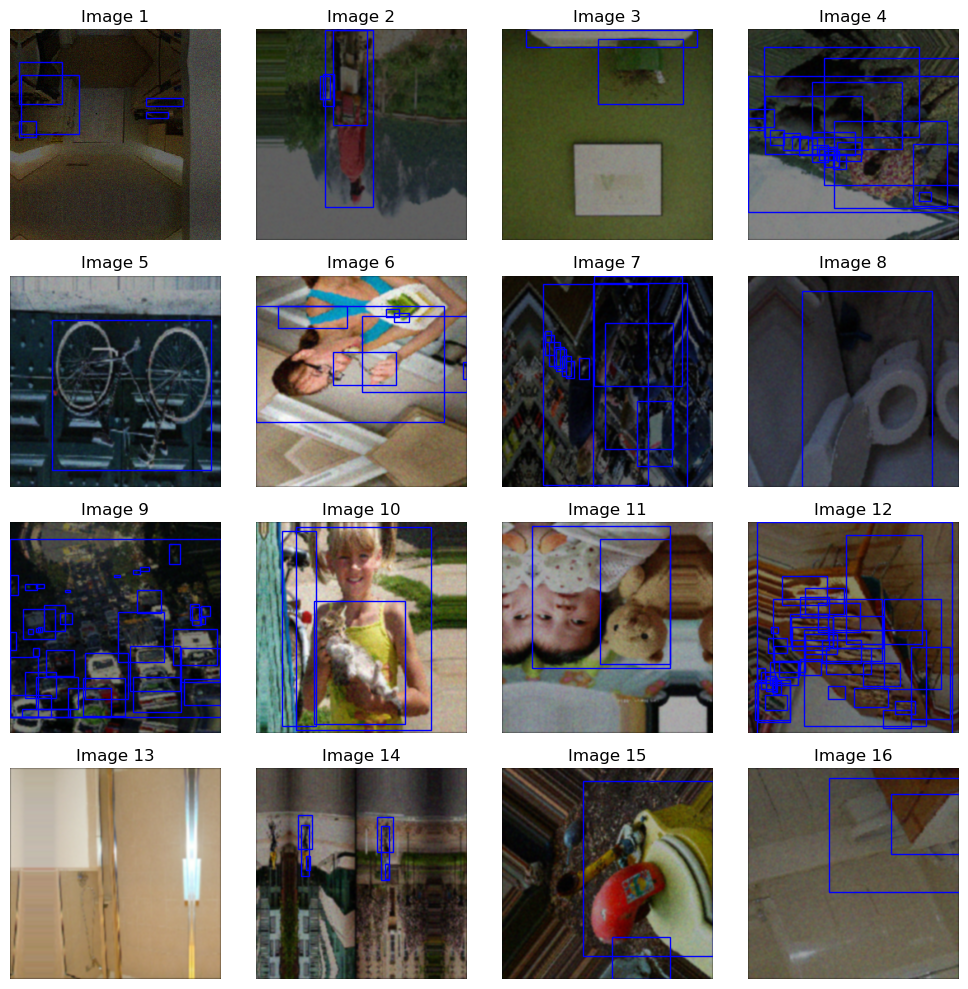

In [34]:
visualize_outputs(test_aug[0], test_aug[1], scale=tf.constant([256, 256, 256, 256], dtype=tf.float32), figsize=(10, 10), linewidth=1, color=[0, 0, 1])

In [24]:
augmenter = Ada(aug_functions=augmentations, img_size=args.img_size, initial_probability=0.0, switch=True)

In [25]:
augmenter.update(tf.constant(0.2))
print(augmenter.probability)
test_ada = augmenter(kvsdk, training=True)

<tf.Variable 'ada_p:0' shape=(1, 1) dtype=float32, numpy=array([[0.639371]], dtype=float32)>


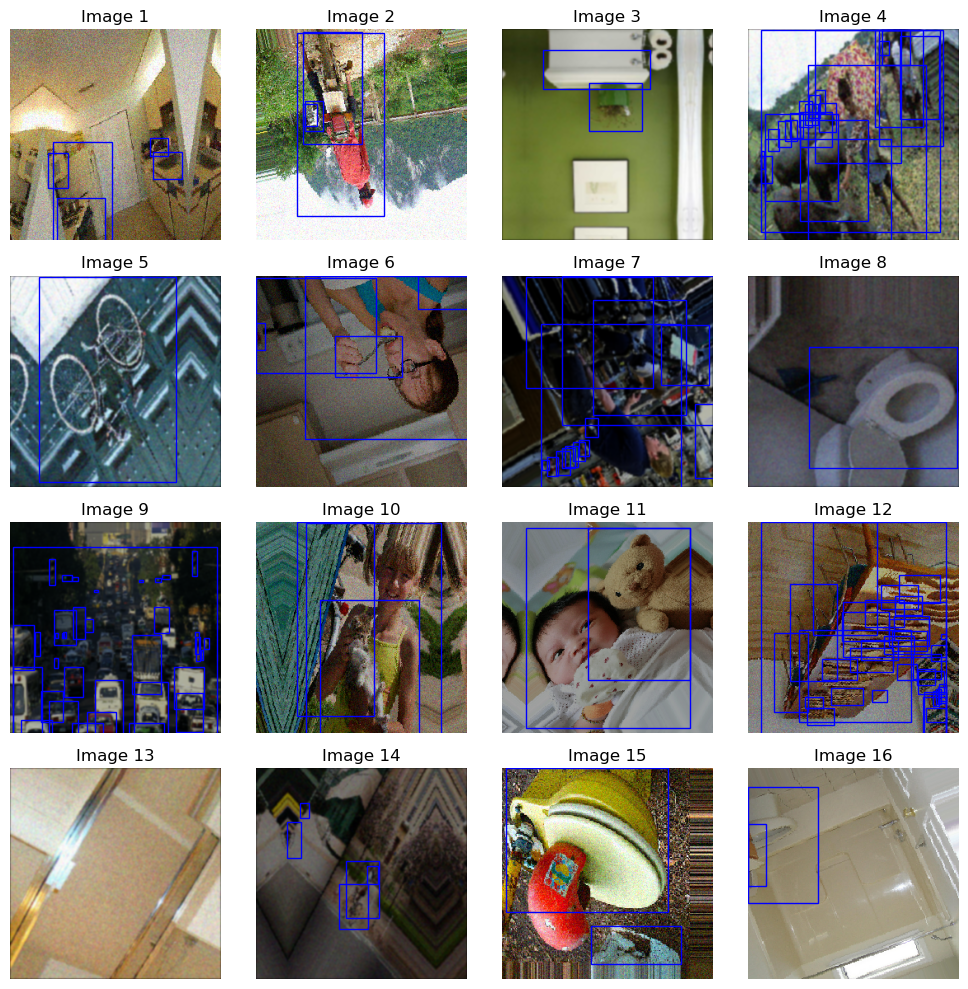

In [26]:
visualize_outputs(test_ada[0], test_ada[1], scale=tf.constant([256, 256, 256, 256], dtype=tf.float32), figsize=(10, 10), linewidth=1, color=[0, 0, 1])

# Model Architecture

In [447]:
def make_dummy_model(img_size):

    if len(img_size) == 2:
        shape = (img_size[0], img_size[1], 3)
    if len(img_size) == 3:
        shape = img_size
    
    inputs = tf.keras.Input(shape=shape)
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding="same", name='Conv1')(inputs)
    x = layers.BatchNormalization(name='BN')(x)
    x = layers.Activation("relu", name='Act')(x)
    x = layers.Conv2D(filters=1, kernel_size=3, activation="sigmoid", padding="same", name='Conv2')(x)
    x = layers.Flatten(name='Flatten')(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(4, activation="sigmoid", name='Dense')(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [708]:
class MyModel(tf.keras.Model):

    def __init__(self, 
                 img_size,
                 augment_func, # ada_p=0.5, ada_batch_p=0.0,
                 **kwargs):
               
        super(MyModel, self).__init__(**kwargs)

        self.img_size = img_size
        self.train_step_counter = tf.Variable(0, dtype=tf.int32, trainable=False)
        self.model = make_dummy_model(img_size)
        self.ada = augment_func

    def compile(self, optimizer=None, metrics=[], *args, **kwargs):

        assert isinstance(metrics, list), "metrics input must be a list"
        self.train_step_counter.assign(0)
        self.optimizer = optimizer

        # Set up MyModel._metrics
        self.augmentation_probability_tracker = tf.keras.metrics.Mean(name="aug_probability")
        self.dice_coeff_tracker = tf.keras.metrics.Mean(name="dice_coeff_metric")  # <-------------------------- change this
        # self.loss_tracker = metrics[0] if len(metrics) == 1 else tf.keras.metrics.Mean(name="loss_metric") ###### Make it so metrics can be multiple items ######
        
        # Set up MyModel.compiled_metrics._metrics
        super(MyModel, self).compile(metrics=metrics, *args, **kwargs)

    @property
    def metrics(self):

        if self.compiled_metrics.built:
            return self.compiled_metrics._metrics[0] + [self.dice_coeff_tracker, self.augmentation_probability_tracker]
        else:
            return [self.dice_coeff_tracker, self.augmentation_probability_tracker]

    def train_step(self, ds_input):

        self.train_step_counter.assign_add(1)
        augmented_images, augmented_masks = self.ada(ds_input, training=True)
        
        with tf.GradientTape() as tape: # target tensor must be tf.float32

            predicted = self.model(augmented_images, training=True) # out: tf.float32 <- in: tf.float32
            loss = self.compiled_loss(augmented_masks, predicted) # out: tf.float32 <- in: tf.float32, tf.float32
            
        trainable_weights = self.model.trainable_weights
        model_grads = tape.gradient(loss, trainable_weights)
        self.optimizer.apply_gradients(zip(model_grads, trainable_weights))
        
        self.ada.update(loss)
        # self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(loss)
        self.dice_coeff_tracker.update_state(1-loss) # <-------------------------- change this
        self.augmentation_probability_tracker.update_state(self.ada.probability)
        
        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs, training=False, augment=False):

        augmented_images, augmented_masks = self.ada(inputs, training=training) if augment else inputs
        predicted = self.model(augmented_images, training=training)
        return augmented_images, augmented_masks, predicted

In [709]:
test_mymodel = MyModel(img_size=(128, 128), augment_func=None)

In [710]:
test_mymodel.compile(optimizer='adam', metrics=[tf.keras.metrics.MeanIoU(num_classes=4, name='meanIOU'), 'bce'], loss=myIOU)

In [717]:
test_mymodel.metrics_names

['meanIOU', 'bce', 'dice_coeff_metric', 'aug_probability']

In [712]:
for i in test_mymodel._metrics:
    print(i.name)

aug_probability
dice_coeff_metric


In [702]:
# test_mymodel.compiled_metrics.build(tf.constant([1.0, 2.0]), tf.constant([1.2, 2.3]))

In [713]:
vars(test_mymodel.compiled_metrics)

{'_output_names': None,
 '_user_metrics': [<keras.metrics.MeanIoU at 0x233aed48a90>, 'bce'],
 '_user_weighted_metrics': None,
 '_metrics': [<keras.metrics.MeanIoU at 0x233aed48a90>, 'bce'],
 '_weighted_metrics': None,
 '_built': False,
 '_from_serialized': False}

In [714]:
test_mymodel.compiled_metrics.update_state(tf.constant([1.0, 2.0]), tf.constant([1.5, 2.1]))

In [715]:
vars(test_mymodel.compiled_metrics)

{'_output_names': ['output_1'],
 '_user_metrics': [<keras.metrics.MeanIoU at 0x233aed48a90>, 'bce'],
 '_user_weighted_metrics': None,
 '_metrics': [[<keras.metrics.MeanIoU at 0x233aed48a90>,
 '_weighted_metrics': [[None]],
 '_built': True,
 '_from_serialized': False,
 '_metrics_in_order': [<keras.metrics.MeanIoU at 0x233aed48a90>,
  <keras.metrics.MeanMetricWrapper at 0x233aed52a60>]}

In [716]:
test_mymodel.compiled_metrics._metrics[0][0].name

'meanIOU'

# Callback

In [ ]:
# Setup Callbacks

# Configuration

In [ ]:
# class Config(object):
#     """
#     Holds the configuration for anything you want it to.
#     To get the currently active config, call get_cfg().

#     To use, just do cfg.x instead of cfg['x'].
#     I made this because doing cfg['x'] all the time is dumb.
#     """

#     def __init__(self, config_dict):
#         for key, val in config_dict.items():
#             self.__setattr__(key, val)

#     def copy(self, new_config_dict={}):
#         """
#         Copies this config into a new config object, making
#         the changes given by new_config_dict.
#         """

#         ret = Config(vars(self))
        
#         for key, val in new_config_dict.items():
#             ret.__setattr__(key, val)

#         return ret

#     def replace(self, new_config_dict):
#         """
#         Copies new_config_dict into this config object.
#         Note: new_config_dict can also be a config object.
#         """
#         if isinstance(new_config_dict, Config):
#             new_config_dict = vars(new_config_dict)

#         for key, val in new_config_dict.items():
#             self.__setattr__(key, val)
    
#     def print(self):
#         for k, v in vars(self).items():
#             print(k, ' = ', v)

# Train

In [ ]:
def setupModel(args, dummy=False):
  
    params = {'anchors': args.anchors, 'classes': args.classes, 
            'projection_dim': args.projection_dim, 'num_heads': args.num_heads, 
            'patch_size_ratio': 1/args.patch_size_ratio, 'img_size': args.img_size}
  

    mymodel = make_dummy_model(params['img_size'])

    model_dir = 'weights/'

    if args.visualize_training == 1:

        sample_img = tf.keras.utils.load_img(os.path.join(os.getcwd(), 'img.png'))
        input_arr = tf.keras.utils.img_to_array(sample_img, data_format='channels_last')
        input_arr = tf.image.resize(input_arr, size=args.img_size, method='nearest')
        example_img = tf.convert_to_tensor(input_arr / 255)

        weights_path = os.path.join(os.getcwd(), model_dir, "weights_epoch_{epoch}")
        print(f"Storing weights at {weights_path}")

        callbacks_list = [tf.keras.callbacks.ModelCheckpoint(filepath=weights_path, 
                                                                monitor="loss", 
                                                                save_best_only=False, 
                                                                save_weights_only=True, 
                                                                verbose=1), DisplayCallback(example_img)]
    else: 

        callbacks_list = [tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.getcwd(), "weights_epoch_{epoch}"), 
                                                                monitor="loss", 
                                                                save_best_only=False, 
                                                                save_weights_only=True, 
                                                                verbose=1)]

    if args.optimizer == 'scd':

        learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
        learning_rate_boundaries = [125, 250, 500, 240000, 360000]

        learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(boundaries=learning_rate_boundaries, values=learning_rates)
        optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)

    if args.optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=2.5e-06)

    return mymodel, customLoss, callbacks_list, optimizer

# Extra

In [ ]:
# class Augmentations(object):

#     def __init__(self, aug_functions):

#         if not isinstance(aug_functions, list):
#             aug_functions = [aug_functions]
#         self.aug_functions = aug_functions

#     def build(self, img_size):

#         if len(img_size) == 2:
#             self.img_shape = img_size + (3,)
    
#         if len(img_size) == 3:
#             self.img_shape = img_size

#         input_img = layers.Input(shape=self.img_shape)
#         input_bboxes = layers.Input(shape=(None, 4))
#         x = (input_img, input_bboxes)
#         for func in self.aug_functions:
#             x = func(x)

#         self.augment_model = tf.keras.Model([input_img, input_bboxes], x, name='obj_det_data_augmentation_function')

#     def visualize_outputs(self, imgs, bboxes, scale, figsize, linewidth, color):

#         num_images = len(imgs)
#         titles = ['Image {}'.format(i+1) for i in range(num_images)]
        
#         rows = np.floor(np.sqrt(num_images))
#         cols = np.ceil(num_images / rows)

#         fig, axes = plt.subplots(int(rows), int(cols), figsize=figsize)
#         for i, ax in enumerate(axes.flat):
#             if i < num_images:
#                 image = imgs[i]
#                 boxes = bboxes[i] * scale
#                 ax.imshow(np.array(image))

#                 for box in boxes:
#                     y1, x1, y2, x2 = box
#                     w, h = x2 - x1, y2 - y1
#                     patch = plt.Rectangle(
#                         [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth)
#                     ax.add_patch(patch)
                    
#                 ax.axis('off')
#                 ax.set_title(titles[i])
#             else:
#                 ax.axis('off')
#         plt.tight_layout()
#         plt.show()

#     def __call__(self, inputs):
        
#         scale = tf.constant(list(self.img_shape[0:2] * 2), dtype=tf.float32)

#         start = time.time()
#         out_imgs, out_bboxes = self.augment_model(inputs)
#         end = time.time()
#         print(f'Data augmentation took {end - start} seconds')
        
#         print('Displaying Images...')
#         self.visualize_outputs(out_imgs, out_bboxes, scale, figsize=(10, 10), linewidth=1, color=[0, 0, 1])